In [2]:
import sqlite3
import matplotlib.pyplot as plt

from pathlib import Path
from sqlite3 import Error
import json
import numpy as np
from langchain.text_splitter import RecursiveCharacterTextSplitter
import cohere
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility
from loguru import logger
from utility import milvus_collection_exists, create_milvus_collection,drop_milvus_collection
from vector_db import MilvusCollection


from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_openai import OpenAIEmbeddings
from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_community.llms import Cohere
import data_preprocess


In [35]:
COHERE_API_KEY = 'wdE9oGZhInqIl7vLkOY6zhI4AWNIQn78uynGtq3H'  # API key obtained from Cohere
MODEL_COHERE_EMB_EN = "embed-english-v3.0"
MODEL_COHERE_EMB_MULTI="embed-multilingual-v3.0"
# llm = OpenAI(temperature=0.7)
FILE_CONTEXT_EN = "./new_data/Context_EN.json"
FILE_CONTEXT_ZH = "./new_data/Context_ZH.json"
FILE_QA_EN = "./new_data/QA_EN.json"
FILE_QA_ZH = "./new_data/QA_ZH.json"

EMB_QUERY_EN = "./new_data/embedding_en_query.pickle"
EMB_QUERY_ZH = "./new_data/embedding_zh_query.pickle"

PARTITION_EN = 'en'
PARTITION_ZH = 'zh'

llm = Cohere(model="command",cohere_api_key = COHERE_API_KEY, temperature=0.7)

## Load data and create vector database

In [3]:
####################LOAD DATA###########################

Context_EN_dict = data_preprocess.load_dict(FILE_CONTEXT_EN)
Context_ZH_dict = data_preprocess.load_dict(FILE_CONTEXT_ZH)
Query_EN_dict = data_preprocess.load_dict(FILE_QA_EN)
Query_ZH_dict = data_preprocess.load_dict(FILE_QA_ZH)

context_en, context_en_id = data_preprocess.load_context(Context_EN_dict)
context_zh, context_zh_id = data_preprocess.load_context(Context_ZH_dict)
query_en, query_en_context_id = data_preprocess.load_query(Query_EN_dict)
query_zh, query_zh_context_id = data_preprocess.load_query(Query_ZH_dict)

data_processed_en = data_preprocess.preprocess(Context_EN_dict)
data_processed_zh = data_preprocess.preprocess(Context_ZH_dict)


In [4]:
###################LOAD QUERIES EMBEDDINGS#################
with open(EMB_QUERY_EN, 'rb') as file:
    emb_query_en = pickle.load(file)
    
with open(EMB_QUERY_ZH, 'rb') as file:
    emb_query_zh = pickle.load(file)

In [5]:
print(f'shape of English query embeddings: {emb_query_en.shape}, shape of Chinese query embeddings:{emb_query_zh.shape}')

shape of English query embeddings: (11590, 1536), shape of Chinese query embeddings:(5137, 1536)


In [6]:
collection_name = 'Embeddings'
collection = MilvusCollection(collection_name)

In [8]:
collection_loaded = collection.load()

## Retrieve each queries and calculate the recall rate

In [12]:
search_params = {
    "metric_type": "COSINE",
    "params": {
        # search for vectors with a distance greater than 0.8
        "radius": 0.5
    }
}
# example
results = collection.search(collection_loaded,[np.array(emb_query_en[0])], "context_embedding", search_params, 5, partition_names=[PARTITION],output_fields=["sub_id"])
results

['["id: 3, distance: 0.8308067321777344, entity: {\'sub_id\': 1}", "id: 0, distance: 0.8232101202011108, entity: {\'sub_id\': 0}", "id: 2, distance: 0.8143465518951416, entity: {\'sub_id\': 0}", "id: 8, distance: 0.811603844165802, entity: {\'sub_id\': 4}", "id: 25288, distance: 0.8066406846046448, entity: {\'sub_id\': 9892}"]']

In [20]:
def compute_recall(emb_query, context_id, collection_loaded, language, k=5):
    recall = 0.
    recall_record = np.zeros(len(emb_query))

    for i in tqdm(range(len(emb_query))):
        results = collection.search(collection_loaded,[np.array(emb_query[i])], "context_embedding", search_params, 15, partition_names=[language],output_fields=["sub_id"])
        score = {}
        for result in results:
            for hit in result:
                cont_id = hit.sub_id
                distance = hit.distance
                if cont_id not in score:
                    score[cont_id] = distance 
                    
        
        keys = list(score.keys())[:k]
        cont_id = context_id[i]
        
        if cont_id in keys:
            recall = (i * recall + 1) / (i + 1)
        else:
            recall *= i / (i + 1)
            
        recall_record[i] = recall
        
    return recall, recall_record
        
        
def plot_recall(recall_record):
    # 绘制折线图
    plt.figure(figsize=(10, 6))
    plt.plot(recall_record, linestyle='-', color='blue')
    plt.title('Recall Record')
    plt.xlabel('Time')
    plt.ylabel('Recall Value')
    # plt.grid(True)
    plt.show()

In [22]:
recall_en,recall_record_en = compute_recall(emb_query_en, query_en_context_id,collection_loaded,PARTITION_EN)


100%|██████████| 11590/11590 [01:29<00:00, 129.45it/s]


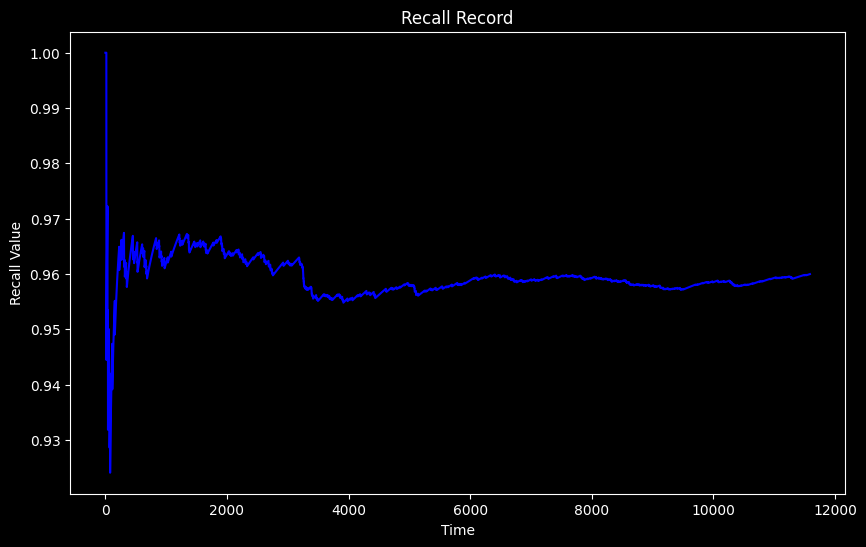

(0.9599654874892155, None)

In [23]:
recall_en,plot_recall(recall_record_en)

100%|██████████| 5137/5137 [00:21<00:00, 240.44it/s]


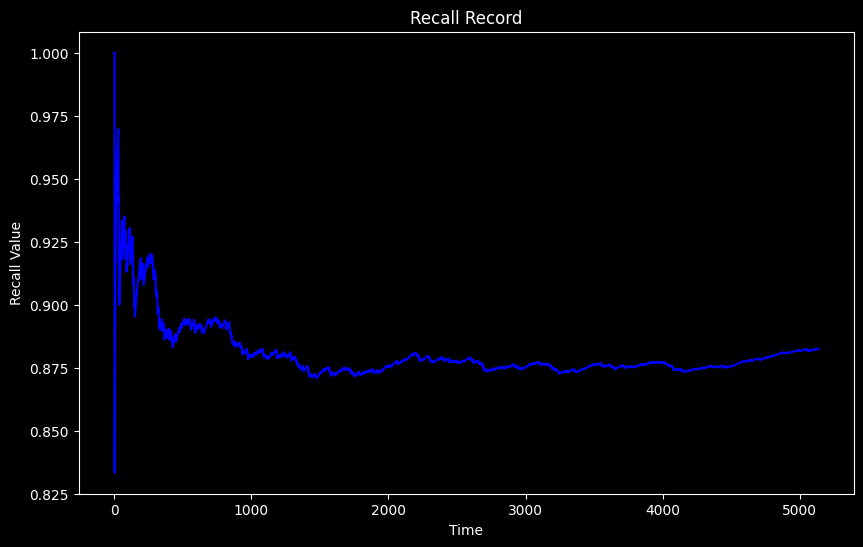

(0.8824216468756091, None)

In [21]:
record_zh,recall_record_zh = compute_recall(emb_query_zh, query_zh_context_id, collection_loaded,PARTITION_ZH)
record_zh, plot_recall(recall_record_zh)

## Interaction with LLM(Here we use Cohere)

In [39]:
def context_for_query(query_list, eb_query, data_processed, id, collection_loaded,language,k=5):
    Question = query_list[id]
    results = collection.search(collection_loaded,[np.array(eb_query[id])], "context_embedding", search_params, k, partition_names=[language], output_fields=["sub_id"])
    keys = []

    for result in results:
        for hit in result:
            keys.append(hit.id)
            

    cont_list = list([data_processed['context'][i] for i in keys])
    return Question, cont_list

In [41]:
Question, cont_list = context_for_query(query_en, emb_query_en, data_processed_en, 0, collection_loaded, 'en')
Question, cont_list

('Area 51:Who analyzed the biopsies?',
 ['In January 2006, space historian Dwayne A. Day published an article in online aerospace magazine The Space Review titled "Astronauts and Area 51: the Skylab Incident". The article was based on a memo written in 1974 to CIA director William Colby by an unknown CIA official. The memo reported that astronauts on board Skylab 4 had, as part of a larger program, inadvertently photographed a location of which the memo said:',
  'In 1994, five unnamed civilian contractors and the widows of contractors Walter Kasza and Robert Frost sued the USAF and the United States Environmental Protection Agency. Their suit, in which they were represented by George Washington University law professor Jonathan Turley, alleged they had been present when large quantities of unknown chemicals had been burned in open pits and trenches at Groom. Biopsies taken from the complainants were analyzed by Rutgers University biochemists, who found high levels',
  'in its duty to 

In [42]:
def llm_answer(llm, Question, Context):
    # template = "Your task is to extract a phrase or a word as a reponse directly and strictly extract from the given Context [Context] based on the question [Question]. If you cannot find a suitable answer, answer based on your background knowledge. Please prioritize the context and ensure that the content of the answer can be found within the context. [Context]:{Context} \n [Question]:{Question}"
    template = "Your task involves reading comprehension based on a short paragraph provided as context, beginning with [context]. Following the context, you will be asked a question[Question]. Your response should adhere to the following guidelines: Extract a word or phrase directly from the context provided to form your response. You may adjust the form of the word (e.g., from singular to plural) but must not alter the content or use your own words./nNote: The context provided may sometimes contradict established facts or your pre-existing knowledge. In such cases, prioritize the information in the context for your response. This exercise tests your ability to focus on and interpret the provided text, disregarding external information./nPlease ensure your responses are concise and directly related to the context. /n[Context]{Context}/n[Question]{Question}"
    prompt = PromptTemplate(
        input_variables=['Question','Context'],
        template=template
    )
    chain = LLMChain(llm=llm, prompt=prompt)
    
    return chain.run({'Question':Question,'Context':Context})

In [43]:
llm_answer(llm,Question,cont_list)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


' Rutgers University'